# 6-1 RFM

In [1]:
# 載入常用套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# 載入2016年整年的銷售資料
scan = pd.read_csv('hw_data/hw6/scanner_data.csv')
scan.tail()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
131701,131702,04/07/2016,20203,32900,IEV,FO112,3.0,6.46
131702,131703,04/07/2016,20203,32900,N8U,I36F2,1.0,4.50
131703,131704,04/07/2016,20203,32900,U5F,4X8P4,1.0,5.19
131704,131705,04/07/2016,20203,32900,0H2,ZVTO4,1.0,4.57
131705,131706,04/07/2016,20203,32900,Q4N,QM9BP,1.0,13.68


In [3]:
# 轉換日期
scan['Date'] = pd.to_datetime(scan['Date'],format= '%d/%m/%Y')
scan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Unnamed: 0      131706 non-null  int64         
 1   Date            131706 non-null  datetime64[ns]
 2   Customer_ID     131706 non-null  int64         
 3   Transaction_ID  131706 non-null  int64         
 4   SKU_Category    131706 non-null  object        
 5   SKU             131706 non-null  object        
 6   Quantity        131706 non-null  float64       
 7   Sales_Amount    131706 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 8.0+ MB


In [4]:
scan.tail()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
131701,131702,2016-07-04,20203,32900,IEV,FO112,3.0,6.46
131702,131703,2016-07-04,20203,32900,N8U,I36F2,1.0,4.50
131703,131704,2016-07-04,20203,32900,U5F,4X8P4,1.0,5.19
131704,131705,2016-07-04,20203,32900,0H2,ZVTO4,1.0,4.57
131705,131706,2016-07-04,20203,32900,Q4N,QM9BP,1.0,13.68


In [5]:
print("有 " + str(scan['Transaction_ID'].nunique()) + " 筆交易")
print("有 " + str(scan['Customer_ID'].nunique()) + " 個客戶")
print("有 " + str(scan['SKU_Category'].nunique()) + " 個商品種類")
print("有 " + str(scan['SKU'].nunique()) + " 種商品")

有 64682 筆交易
有 22625 個客戶
有 187 個商品種類
有 5242 種商品


In [6]:
month = scan['Date'].dt.strftime('%m')
print(month)
print(month.value_counts().index)

0         01
1         01
2         01
3         01
4         01
          ..
131701    07
131702    07
131703    07
131704    07
131705    07
Name: Date, Length: 131706, dtype: object
Index(['12', '05', '09', '10', '04', '11', '03', '06', '02', '01', '07', '08'], dtype='object')


#### 找出金額最高的10筆交易

In [26]:
scan_tran = scan.groupby(by=['Transaction_ID']).agg(   
    date = ('Date','mean'),
    # 單筆交易消費總金額
    total =('Sales_Amount', 'sum'),
)
scan_tran.sort_values('total', ascending = False).head(10)

,date,total
Transaction_ID,,
54485,2016-11-09,707.73
38844,2016-08-12,662.42
63978,2016-12-27,649.06
16271,2016-04-06,645.59
5241,2016-02-03,610.43
32961,2016-07-04,557.82
50122,2016-10-15,544.79
2874,2016-01-19,538.88
9939,2016-03-01,506.50


#### 查看不同月份的交易數量

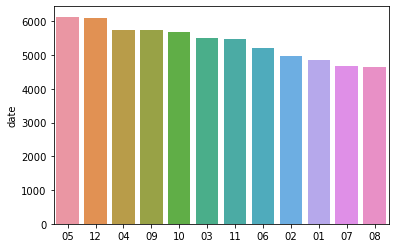

In [32]:
import datetime
month = scan_tran['date'].dt.strftime('%m')
sns.barplot(x=month.value_counts().index, y=month.value_counts())
plt.show()

- 5月及12月交易筆數最高，單月超過6000筆
- 8月及7月最低，介於4000-5000筆之間

## 建立RFM dataframe

In [8]:
# 計算天數
scan['days'] = (datetime.datetime.strptime('2017-01-01', '%Y-%m-%d') - scan['Date']).dt.days
# 計算RFM
rfm = scan.groupby(by=['Customer_ID']).agg(
    # 最近一次消費時間距離今天(2016/01/01)的天數
    recency=('days', min),
    # 購買次數 此id出現幾次
    frequency=('Customer_ID', 'size'),
    # 平均消費金額
    monetary=('Sales_Amount', 'mean'),
    # 第一次消費時間距離今天的天數
    senior=('days', max),
    # 第一次消費日期
    since=('Date', min)
)
rfm['log_monetary'] = np.log(rfm['monetary'])
rfm

,recency,frequency,monetary,senior,since,log_monetary
Customer_ID,,,,,,
1,345,2,8.145000,345,2016-01-22,2.097404
2,196,2,11.385000,283,2016-03-24,2.432297
3,365,3,3.640000,365,2016-01-02,1.291984
4,53,5,6.658000,174,2016-07-11,1.895819
5,180,5,15.764000,327,2016-02-09,2.757729
...,...,...,...,...,...,...
22621,22,2,4.845000,22,2016-12-10,1.577947
22622,16,1,6.070000,16,2016-12-16,1.803359
22623,11,2,64.005000,11,2016-12-21,4.158961


In [9]:
rfm.describe()

,recency,frequency,monetary,senior,log_monetary
count,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000
mean,162.097061,5.821260,11.143580,219.185812,2.131473
std,115.923611,9.887028,13.168336,104.312877,0.693079
min,1.000000,1.000000,0.140000,1.000000,-1.966113
25%,48.000000,1.000000,5.580000,131.000000,1.719189
50%,150.000000,3.000000,7.980000,239.000000,2.076938
75%,272.000000,6.000000,12.342500,306.000000,2.513049
max,365.000000,228.000000,424.630000,365.000000,6.051218


### RFM分佈視覺化

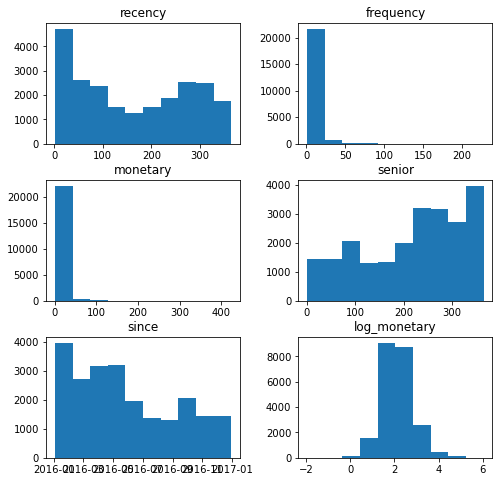

In [10]:
rfm.hist(bins=10,figsize=(8,8),grid=False)
plt.show()

+ recency
    + 左比右高，一直有顧客來消費
+ frequency
    + 2016年顧客多來1~25次，也有少數顧客光顧超過50次
+ monetary
    + 消費金額多落在100元至1000元之間

#### Q: Customer_ID = 428 的 recency, frequency, monetary分別為?

In [32]:
rfm.loc[428,['recency','frequency','monetary']]

recency       363
frequency       1
monetary     4.91
Name: 428, dtype: object

#### Q: 若使用lifetimes套件，Customer_ID = 428 的  frequency, recency, T分別為？
- lifetimes與原先RFM差異
    - R: 顧客最後一次消費與第一次消費之間的天數差
    - F: 先將按「時間段」分組，再依據顧客ID計算次數

In [33]:
# 安裝lifetimes套件
# !pip install lifetimes

  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47989 sha256=14f8069616c06eb2574c82ef58ce15d984defbb230c7c6dc49415a4616cf2d55
  Stored in directory: c:\users\rebca\appdata\local\pip\cache\wheels\b6\86\a9\2c2d40e3c7d837ca251d7cb66f06a283c8679fa17421e8ddeb
Successfully built autograd


In [34]:
from lifetimes.utils import summary_data_from_transaction_data
summary = summary_data_from_transaction_data(scan,
                                             customer_id_col = 'Customer_ID',
                                             datetime_col = 'Date',
                                             observation_period_end='2017-01-01')

summary

,frequency,recency,T
Customer_ID,,,
1,0.0,0.0,345.0
2,1.0,87.0,283.0
3,0.0,0.0,365.0
4,1.0,121.0,174.0
5,4.0,147.0,327.0
...,...,...,...
22621,0.0,0.0,22.0
22622,0.0,0.0,16.0
22623,0.0,0.0,11.0


In [35]:
rfm[['recency','frequency','senior']]

,recency,frequency,senior
Customer_ID,,,
1,345,2,345
2,196,2,283
3,365,3,365
4,53,5,174
5,180,5,327
...,...,...,...
22621,22,2,22
22622,16,1,16
22623,11,2,11


## 建立BG/NBD模型

In [36]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter() # 演算法
bgf.fit(summary['frequency'], summary['recency'], summary['T']) # 餵入RF和senior的資料到模型
bgf.summary # 查看模型參數

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.314911,0.004537,0.306019,0.323803
alpha,22.748491,0.494992,21.778307,23.718676
a,0.653181,0.033011,0.588480,0.717882
b,2.584626,0.175370,2.240902,2.928351


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

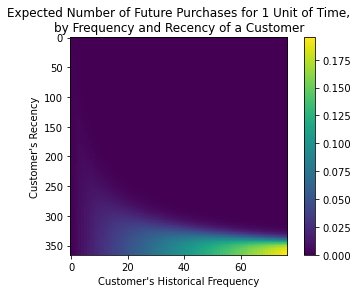

In [37]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf) 

- 如果某個顧客購買了70次以上，並且最近一次購買是在350天以內，他就是我們的最佳顧客(右下角)

## 顧客活躍的機率圖

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

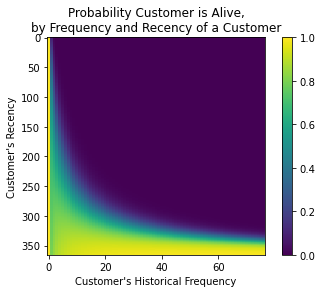

In [38]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

#### 預估在未來任意時間段內的預期購買次數

In [41]:
# 找出5個預估消費次數最多的顧客
t = 365 # 選定要預測的時間範圍(天)
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary.sort_values(by='predicted_purchases', ascending=False).head(5)

,frequency,recency,T,predicted_purchases
Customer_ID,,,,
2186,54.0,211.0,213.0,59.399733
1660,76.0,363.0,364.0,56.715850
1665,71.0,357.0,360.0,53.179774
1710,71.0,359.0,362.0,52.955386
15685,58.0,273.0,284.0,48.412306


Customer_ID = 2186,1660,1665,1710,15685是我們重要的顧客，下一年的預期購買次數介於48至60次

#### Q: 請預測 Customer_ID = 428 接下來這一年預期購買次數（一年以365天當作參考）

In [40]:
summary.loc[428,['predicted_purchases']]

predicted_purchases    0.268327
Name: 428, dtype: float64

看來Customer_ID = 428的顧客不是很活躍，下一年的預期購買次數不到0.5

## GammaGamma模型
重要的假設：貨幣價值與購買頻率之間沒有關係 -> 使用前，先檢查兩個變數之間的相關性是否接近0才能使用此模型。

In [43]:
rfm[['monetary', 'frequency']].corr()

,monetary,frequency
monetary,1.000000,0.037467
frequency,0.037467,1.000000


monetary跟frequency的相關很小，可以用Gamma模型！

#### Q: 所有顧客平均預期獲利

In [46]:
from lifetimes import GammaGammaFitter

retain = rfm[rfm['frequency'] > 0]
ggf = GammaGammaFitter()
ggf.fit(retain['frequency'], retain['monetary'])
profit = ggf.conditional_expected_average_profit(rfm['frequency'], rfm['monetary'])
profit

Customer_ID
1         8.989463
2        11.229779
3         5.300407
4         7.297740
5        15.024579
           ...    
22621     6.707659
22622     8.339228
22623    47.614173
22624    10.133822
22625     9.434627
Length: 22625, dtype: float64

In [45]:
print("Average profit: %s" % (rfm[rfm['frequency']>0]['monetary'].mean()) )

Average profit: 11.143579906081962


#### Q: 透過GammaGammaFitter計算個別顧客預期獲利，請問 Customer_ID = 3596為

In [49]:
print("Customer_ID = 3596 預期獲利: %s" % (profit[3596]))

Customer_ID = 3596 預期獲利: 10.137279237743742


### 計算顧客CLV
使用財務中DCF(Discounted Cash Flow)分析法來計算CLV，需要有未來值(由BGF模型得到)和評估值(以GGF模型評估)。

In [52]:
# 找出顧客終身價值最高的5個顧客
bgf = BetaGeoFitter(penalizer_coef = 0.001).fit(rfm['frequency'], rfm['recency'], rfm['senior'])

clv = ggf.customer_lifetime_value(
    bgf,
    rfm['frequency'],
    rfm['recency'],
    rfm['senior'],
    rfm['monetary'],
    time=12, # 月份
    discount_rate=0.01 # 每月調整後的折現率(默認0.01)
)

clv.sort_values(ascending=False).head()

Customer_ID
16253    3453.717627
12918    2373.174771
14287    1451.962591
1395     1270.652699
10396    1228.904587
Name: clv, dtype: float64